In [1]:
# 기본 라이브러리 임포트
import pandas as pd             
import numpy as np             
import matplotlib.pyplot as plt 
import seaborn as sns           
import gc                       # 가비지 컬렉션(메모리 해제)
import re                       # 정규 표현식 처리
from collections import defaultdict  # 기본값이 있는 딕셔너리 생성

# 경고 메시지 억제
import warnings
warnings.filterwarnings('ignore')   

# 그래프 스타일 설정
sns.set()                           # seaborn 기본 스타일 적용

# matplotlib 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 한글 폰트 설정
# plt.rcParams['font.family'] = 'AppleGothic'  
plt.rcParams['figure.figsize'] = (12, 6)       # 그림 크기 설정 (가로, 세로)
plt.rcParams['font.size'] = 14                 # 폰트 크기 설정
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 기호 깨짐 방지

# 결측치 시각화 라이브러리 임포트
import missingno                          # 결측치 분포를 시각화하는 유틸리티

# 범주형 변수 레이블 인코딩을 위한 도구 임포트
from sklearn.preprocessing import LabelEncoder

# 중복 조합 생성에 사용할 product 함수 임포트
from itertools import product

# 회귀 및 통계 분석을 위한 statsmodels 임포트
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler

In [2]:
# features_importances CSV 파일 (12월 데이터만 존재)
df = pd.read_csv('병합_selected_features.csv')

# df1 Parquet 파일 불러오기
df1 = pd.read_parquet('open/concat/2018_마케팅정보.parquet')

# df1에서 df와 공통이거나 '캠페인'으로 시작하거나 'Segment' 컬럼 추출
cols_df = df.columns.tolist()
common_cols = [
    col
    for col in df1.columns
    if col in cols_df or col.startswith('캠페인')
]

# df1에서 공통+캠페인 컬럼만 추출해 df2 생성
df2 = df1[common_cols]

# ID와 Segment만 추출
segment_df = df[['ID', 'Segment']]

# df1에서 공통+캠페인 컬럼으로 만든 df2에 Segment 병합
df2 = df2.merge(segment_df, on='ID', how='left')

# 결과 확인
display(df2)

,ID,컨택건수_이용유도_EM_B0M,컨택건수_이용유도_인터넷_B0M,컨택건수_이용유도_EM_R6M,컨택건수_채권_B0M,캠페인접촉건수_R12M,캠페인접촉일수_R12M,Segment
0,TRAIN_000000,13,0,57,0,1회 이상,1일 이상,D
1,TRAIN_000001,0,1,2,0,15회 이상,10일 이상,E
2,TRAIN_000002,0,0,12,0,1회 이상,1일 이상,C
3,TRAIN_000003,13,0,35,0,1회 이상,1일 이상,D
4,TRAIN_000004,0,0,0,0,1회 이상,1일 이상,E
...,...,...,...,...,...,...,...,...
2999995,TEST_99995,0,0,0,0,1회 이상,1일 이상,NaN
2999996,TEST_99996,2,1,9,0,1회 이상,1일 이상,NaN
2999997,TEST_99997,1,0,12,0,1회 이상,1일 이상,NaN
2999998,TEST_99998,0,0,0,0,5회 이상,5일 이상,NaN


In [3]:
df2.dtypes

ID                   object
컨택건수_이용유도_EM_B0M      int64
컨택건수_이용유도_인터넷_B0M     int64
컨택건수_이용유도_EM_R6M      int64
컨택건수_채권_B0M           int64
캠페인접촉건수_R12M         object
캠페인접촉일수_R12M         object
Segment              object
dtype: object

In [4]:
# 컬럼명 리스트 생성 캠페인
campaign_cols = [col for col in df2.columns if col.startswith('캠페인')]

# 캠페인 컬럼 숫자 변환
for col in campaign_cols:
    df2[col] = df2[col].astype(str).str.extract(r'(\d+)').astype(float)

display (df2[campaign_cols].value_counts())

캠페인접촉건수_R12M  캠페인접촉일수_R12M
1.0           1.0             2136078
5.0           5.0              408736
10.0          10.0             148309
15.0          15.0              94491
5.0           1.0               57015
20.0          15.0              42941
              20.0              35813
10.0          5.0               34302
15.0          10.0              26932
1.0           5.0               13411
5.0           10.0               1773
10.0          15.0                152
1.0           10.0                 25
10.0          1.0                  16
25.0          20.0                  6
Name: count, dtype: int64

,캠페인접촉건수_R12M,캠페인접촉일수_R12M
count,3000000,3000000
mean,3,3
std,4,4
min,1,1
25%,1,1
50%,1,1
75%,5,5
max,25,20


Segment,A,B,C,D,E
캠페인접촉건수_R12M,0,0,5,15,80
캠페인접촉일수_R12M,0,0,5,15,80


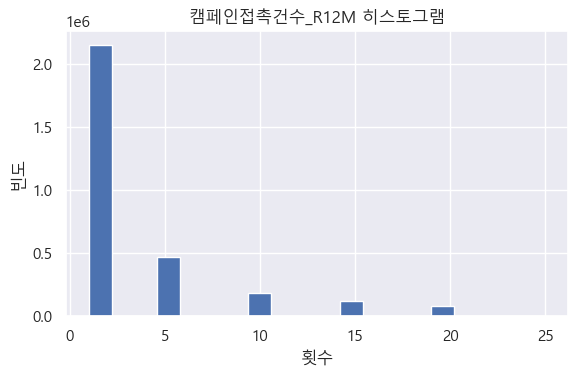

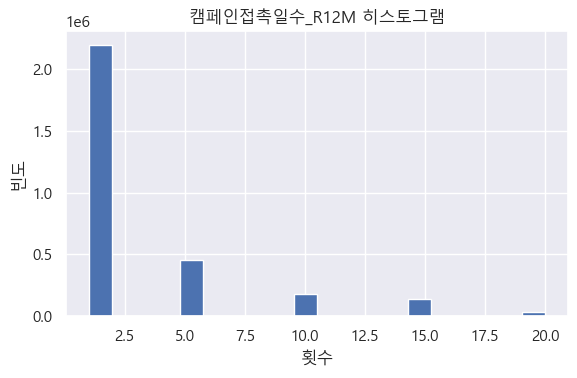

In [5]:
# float 출력 포맷 설정 (과학표기 없이 정수 형태로)
pd.set_option('display.float_format', '{:.0f}'.format)

# 통계 출력 (scientific notation 없이)
display (df2[campaign_cols].describe())

# 세그먼트 분포 계산
segment_dist = (
    df2['Segment']
    .value_counts(normalize=True)
    .sort_index()
    .mul(100)
    .round(2)
)

# 캠페인별 동일 분포로 테이블 생성
dist_df = pd.DataFrame({c: segment_dist for c in campaign_cols}).T
dist_df.columns = segment_dist.index

# 결과 출력
display(dist_df)

# 히스토그램 시각화 캠페인 컬럼별
for col in campaign_cols:
    plt.figure(figsize=(6, 4))
    df2[col].hist(bins=20)
    plt.title(f'{col} 히스토그램')
    plt.xlabel('횟수')
    plt.ylabel('빈도')
    plt.tight_layout()
    plt.show()

### EDA
- 대부분의 값이 0에 몰려 있기 때문에, 0과 0이 아닌 값을 구분하여 분석을 진행

,비0 비율(%)
컨택건수_이용유도_EM_B0M,31
컨택건수_이용유도_인터넷_B0M,20
컨택건수_이용유도_EM_R6M,72


,비0 비율(%)
컨택건수_이용유도_EM_B0M,31


,컨택건수_이용유도_EM_B0M 비0 그룹 통계
count,926824
mean,6
median,2
std,5
min,1
max,14


,컨택건수_이용유도_EM_B0M 비0 비율(%)
Segment,
A,47
B,68
C,45
D,44
E,28


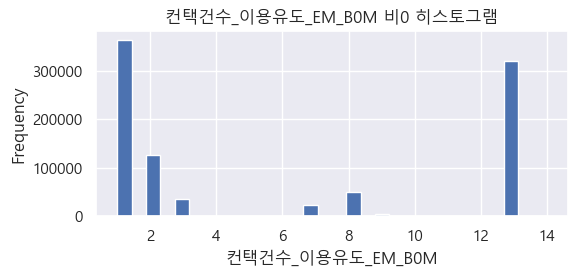

,비0 비율(%)
컨택건수_이용유도_인터넷_B0M,20


,컨택건수_이용유도_인터넷_B0M 비0 그룹 통계
count,592816
mean,1
median,1
std,0
min,1
max,1


,컨택건수_이용유도_인터넷_B0M 비0 비율(%)
Segment,
A,21
B,12
C,18
D,19
E,20


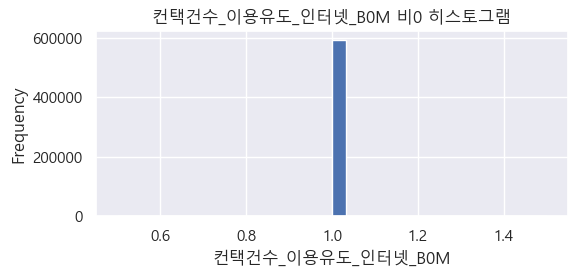

,비0 비율(%)
컨택건수_이용유도_EM_R6M,72


,컨택건수_이용유도_EM_R6M 비0 그룹 통계
count,2164405
mean,17
median,6
std,21
min,1
max,79


,컨택건수_이용유도_EM_R6M 비0 비율(%)
Segment,
A,83
B,90
C,83
D,83
E,69


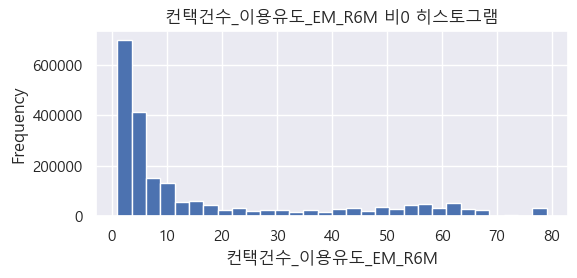

In [6]:
# 분석에서 제외할 컬럼 리스트
exclude_cols = ['ID', 'Segment', '캠페인접촉건수_R12M', '캠페인접촉일수_R12M']

# 0 vs 비0 플래그 대상으로 사용할 수치형 컬럼 리스트
num_cols = [
    col for col in df2.select_dtypes(include='number').columns
    if col not in exclude_cols
]

# 비0 비율 계산 후, 5% 이상 95% 이하인 컬럼만 선별
ratio = {col: (df2[col] != 0).mean() * 100 for col in num_cols}
valid_cols = [col for col, pct in ratio.items() if 5 <= pct <= 95]

# 유효 컬럼 목록 출력
display(pd.DataFrame({'비0 비율(%)': [ratio[c] for c in valid_cols]}, index=valid_cols))

# 유효 컬럼들에 대해 EDA 수행
for orig_col in valid_cols:
    # 비0 플래그 생성
    flag_col = f'{orig_col}_flag'
    df2[flag_col] = (df2[orig_col] != 0).astype(int)
    
    # 비0 비율 계산 및 출력
    pct_nonzero = ratio[orig_col]
    display(pd.DataFrame({'비0 비율(%)': [pct_nonzero]}, index=[orig_col]))
    
    # 비0 그룹 통계 요약 출력
    group_stats = df2[df2[flag_col] == 1][orig_col].agg(
        ['count', 'mean', 'median', 'std', 'min', 'max']
    )
    display(group_stats.to_frame(name=f'{orig_col} 비0 그룹 통계'))
    
    # 세그먼트별 비0 비율 교차표 출력
    cross_tab = pd.crosstab(df2['Segment'], df2[flag_col], normalize='index') * 100
    display(cross_tab[1].to_frame(name=f'{orig_col} 비0 비율(%)'))
    
    # 비0 값 히스토그램 시각화
    non_zero_values = df2.loc[df2[flag_col] == 1, orig_col]
    plt.figure(figsize=(6,3))
    plt.hist(non_zero_values, bins=30)
    plt.title(f'{orig_col} 비0 히스토그램')
    plt.xlabel(orig_col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

### 0이 아닌 값들 중 B의 비율이 높은 컬럼들

In [7]:
# 분석 대상 컬럼 리스트 설정
cols = [
    '컨택건수_이용유도_EM_B0M',
    '컨택건수_이용유도_EM_R6M'
]

# 비0 플래그 생성
for c in cols:
    df2[f'{c}_flag'] = (df2[c] != 0).astype(int)

# 합산 지표 생성
flag_cols = [f'{c}_flag' for c in cols]
df2['contact_score'] = df2[flag_cols].sum(axis=1)

# 세그먼트별 평균과 표준편차 계산
segment_mean = df2.groupby('Segment')['contact_score'].mean().sort_index()
segment_std  = df2.groupby('Segment')['contact_score'].std().sort_index()

# mean_df 생성
mean_df = pd.DataFrame({
    'Segment': segment_mean.index,
    'mean_contact': segment_mean.values,
    'std_contact': segment_std.values
})

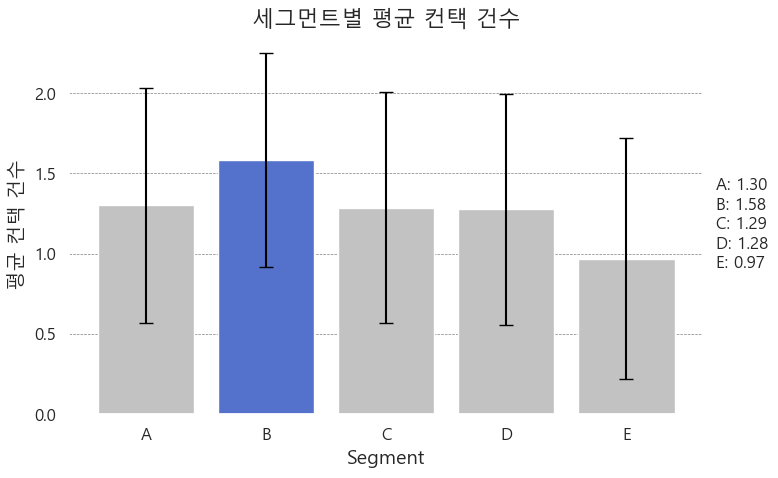

In [8]:
# 플롯 그리기
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_axisbelow(True)

palette = ['#C2C2C2', '#4068E0', '#C2C2C2', '#C2C2C2', '#C2C2C2']
bars = sns.barplot(
    data=mean_df,
    x='Segment',
    y='mean_contact',
    ax=ax,
    ci=None,
    palette=palette
)

# matplotlib으로 에러바 추가
x_positions = [bar.get_x() + bar.get_width() / 2 for bar in bars.patches]
means  = mean_df['mean_contact'].values
errors = mean_df['std_contact'].values
ax.errorbar(
    x=x_positions,
    y=means,
    yerr=errors,
    fmt='none',
    capsize=5,
    color='black',
    zorder=2
)

# 오른쪽 바깥에 평균값 정보 박스
info_text = '\n'.join(
    f"{seg}: {val:.2f}"
   for seg, val in zip(mean_df['Segment'], mean_df['mean_contact'])
)
ax.text(
    1.02, 0.5, info_text,
    transform=ax.transAxes,
    fontsize=12,
    va='center',
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9)
)

# 레이블·타이틀·그리드
ax.set_title('세그먼트별 평균 컨택 건수', fontsize=16)
ax.set_xlabel('Segment', fontsize=14)
ax.set_ylabel('평균 컨택 건수', fontsize=14)
ax.tick_params(labelsize=12)
ax.grid(axis='y', linestyle='--', linewidth=0.5, color='gray')

fig.patch.set_facecolor('white')
ax.set_facecolor('white')
plt.tight_layout()
plt.show()

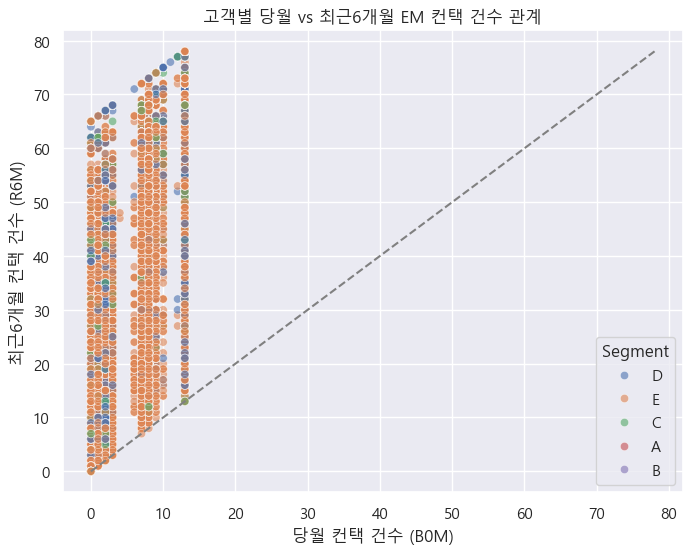

In [9]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='컨택건수_이용유도_EM_B0M',
    y='컨택건수_이용유도_EM_R6M',
    hue='Segment',
    alpha=0.6,
    data=df
)
plt.plot([0, df[['컨택건수_이용유도_EM_B0M','컨택건수_이용유도_EM_R6M']].max().max()],
         [0, df[['컨택건수_이용유도_EM_B0M','컨택건수_이용유도_EM_R6M']].max().max()],
         color='gray', linestyle='--')
plt.title('고객별 당월 vs 최근6개월 EM 컨택 건수 관계')
plt.xlabel('당월 컨택 건수 (B0M)')
plt.ylabel('최근6개월 컨택 건수 (R6M)')
plt.legend(title='Segment')
plt.show()

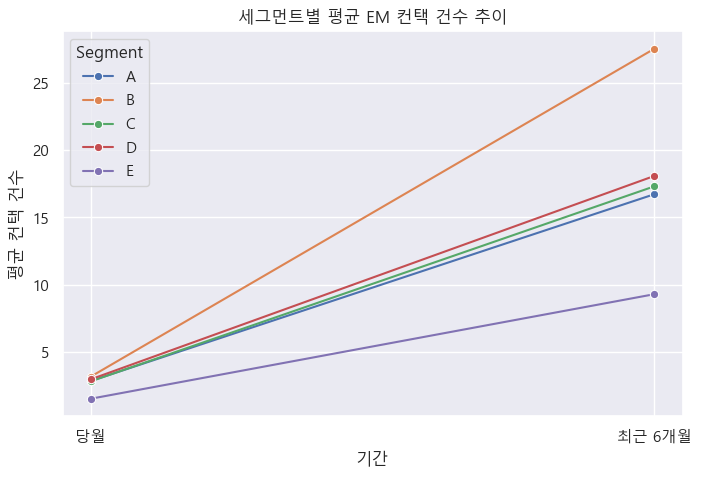

In [10]:
# 세그먼트별 평균 계산
mean_df = (
    df.groupby('Segment')[['컨택건수_이용유도_EM_B0M','컨택건수_이용유도_EM_R6M']]
      .mean()
      .reset_index()
)

# long 포맷으로 변환
mean_long = pd.melt(
    mean_df,
    id_vars='Segment',
    var_name='기간',
    value_name='평균_컨택건수'
)

# 시간축(line) 플롯
plt.figure(figsize=(8,5))
ax = sns.lineplot(
    data=mean_long,
    x='기간',
    y='평균_컨택건수',
    hue='Segment',
    marker='o'
)

# x축 레이블을 '당월', '최근 6개월'로 변경
ax.set_xticks([0, 1])
ax.set_xticklabels(['당월', '최근 6개월'])

plt.title('세그먼트별 평균 EM 컨택 건수 추이')
plt.xlabel('기간')
plt.ylabel('평균 컨택 건수')
plt.show()

### 1. 세그먼트별 평균 EM 컨택 건수 비교 (Bar Plot)

- **B 세그먼트**의 평균 이메일 접촉 건수는 약 **1.58건**으로 가장 높아, **이메일 잦은 접촉**의 핵심 타깃  
- **E 세그먼트**는 평균 약 **0.97건**으로 가장 낮아, 상대적으로 **저관여(low-engagement)** 그룹으로 분류됨
- **A(1.30건)**, **C(1.29건)**, **D(1.28건)** 는 평균 차이가 크지 않으나, **E**보다는 약간 높은 수준

**표준편차(σ) 분석**  
- 각 세그먼트의 σ는 **약 0.65–0.75**로 큰 차이가 없어, 분포 폭은 전반적으로 유사

**종합 해석**  
1. **B 그룹**: 잦은 이메일 접촉을 통해 **우선 유지**해야 할 핵심 타깃
2. **E 그룹**: 최소한의 이메일 접촉만 이루어지는 **저관여** 고객으로, 별도 관리 전략이 필요해보임
3. **A·C·D 그룹**: 중간 스펙트럼에 위치하므로, **추가 세분화 및 맞춤형 이메일 마케팅** 전략 설계가 필요해보임

---

### 2. 고객별 당월 vs. 최근 6개월 EM 컨택 건수 관계 (Scatter Plot)
- **대각선 위 점들**: “6개월 누적 컨택 건수 > 당월 컨택 건수”인 고객  
  - 대부분 점이 대각선 위에 위치 → 장기간 누적 노출이 단기 노출보다 많음  
- **세그먼트별 분포 차이**  
  - **B 세그먼트**: 당월 최대 약 20건, 6개월 최대 약 80건으로 분포 폭이 가장 넓음  
  - **A/C/D 세그먼트**: 당월 약 3 - 12건, 6개월 약 10 - 18건 사이에 집중  
  - **E 세그먼트**: 당월 0 - 5건, 6개월 0 - 10건으로 가장 낮고 좁은 분포  
- **의미**: B 세그먼트가 타 세그먼트 대비 EM 노출이 월등히 높아 주요 마케팅 타깃이며, E 세그먼트는 저관여 그룹으로 판단

---

### 3. 세그먼트별 평균 EM 컨택 건수 추이 (Line Plot)
- **증가 폭(당월→6개월)**  
  - **B**: 약 3 → 27건으로 가장 가파르게 상승  
  - **D**: 약 3 → 18건, **C/A**: 약 3 → 17건 순  
  - **E**: 약 1.5 → 9건으로 완만한 상승  
- **절대값 차이**  
  - B 세그먼트가 가장 높은 평균 노출  
  - E 세그먼트가 가장 낮은 평균 노출  
- **의미**:  
  - B 세그먼트에 마케팅 노출이 집중되어 있으며,  
  - E 세그먼트는 별도 리인게이지먼트 전략 필요  
  - A/C/D 세그먼트는 중간 수준으로 균일하게 노출됨

### 회원 정보 데이터에 있는 메일 수신거부 여부 컬럼 & 마케팅 동의 여부 컬럼 가져와서 같이 보기

In [11]:
# 회원정보 불러오기
member_df = pd.read_parquet('2018_train_회원정보.parquet')

# df2는 이전에 만든 컨택 건수 정보가 들어 있는 DataFrame
merged_df = member_df.merge(
    df2[['ID',
         '컨택건수_이용유도_EM_B0M',
         '컨택건수_이용유도_EM_R6M']],
    on='ID',
    how='left'
)

그룹별 고객 수:
 email_segment
이메일_전수신_허용     9093786
마케팅_비동의        2735898
동의했으나_이메일제외    2570316
Name: count, dtype: int64

그룹별 R6M EM 컨택 건수 평균:
 email_segment
동의했으나_이메일제외    4
마케팅_비동의        3
이메일_전수신_허용    18
Name: 컨택건수_이용유도_EM_R6M, dtype: float64


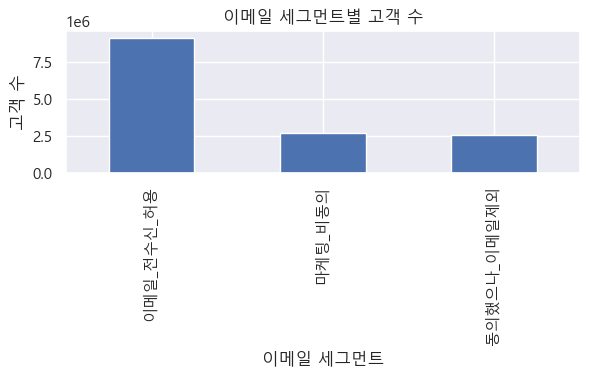

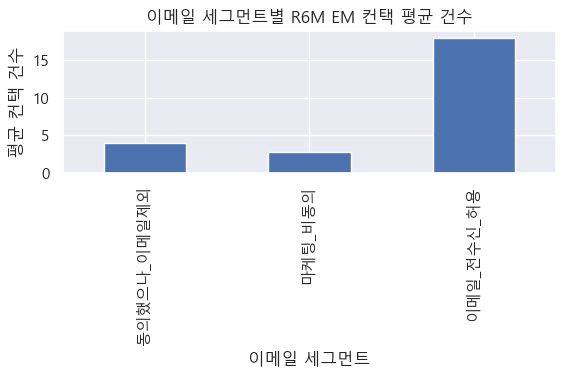

In [12]:
#   1) 마케팅 동의했으나 이메일만 뺀 고객
#   2) 이메일 수신을 모두 오케이한 고객
#   3) 아예 동의 자체를 안 한 고객
conditions = [
    (merged_df['마케팅동의여부'] == 1) & (merged_df['수신거부여부_메일'] == 1),
    (merged_df['마케팅동의여부'] == 1) & (merged_df['수신거부여부_메일'] == 0),
    (merged_df['마케팅동의여부'] == 0)
]
choices = [
    '동의했으나_이메일제외',
    '이메일_전수신_허용',
    '마케팅_비동의'
]
merged_df['email_segment'] = np.select(conditions, choices, default='기타')

# 각 그룹별 고객 수 확인
group_counts = merged_df['email_segment'].value_counts()
print("그룹별 고객 수:\n", group_counts)

# 그룹별 최근 6개월 EM 컨택 건수 평균 비교
avg_contacts = merged_df.groupby('email_segment')['컨택건수_이용유도_EM_R6M'].mean()
print("\n그룹별 R6M EM 컨택 건수 평균:\n", avg_contacts)

# 그룹별 고객 수 시각화
plt.figure(figsize=(6,4))
group_counts.plot(kind='bar')
plt.title('이메일 세그먼트별 고객 수')
plt.xlabel('이메일 세그먼트')
plt.ylabel('고객 수')
plt.tight_layout()
plt.show()

# 그룹별 최근 6개월 EM 컨택 건수 평균 시각화
plt.figure(figsize=(6,4))
avg_contacts.plot(kind='bar')
plt.title('이메일 세그먼트별 R6M EM 컨택 평균 건수')
plt.xlabel('이메일 세그먼트')
plt.ylabel('평균 컨택 건수')
plt.tight_layout()
plt.show()

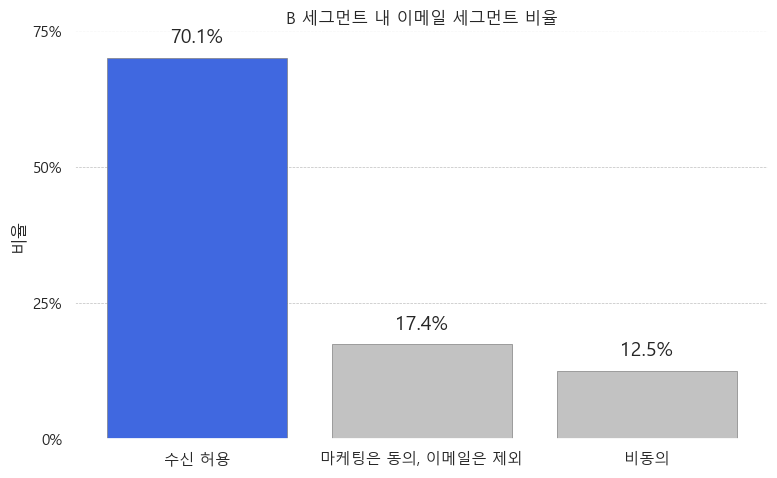

In [13]:
# 이메일 세그먼트별 비율 (지정 팔레트, 중앙 정렬, y축 ticks 조정)
b_df = merged_df[merged_df['Segment']=='B'].copy()
b_email_prop = b_df['email_segment'].value_counts(normalize=True)

fig, ax = plt.subplots(figsize=(8, 5))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# 지정 팔레트
palette = ['#4068E0', '#C2C2C2', '#C2C2C2']

# 막대 그리기 (edgecolor·linewidth로 실선 약하게)
bars = ax.bar(
    x=range(len(b_email_prop)),
    height=b_email_prop.values,
    color=palette,
    edgecolor='gray',
    linewidth=0.5
)

# x축 레이블 매핑 및 중앙 정렬
label_map = {
    '이메일_전수신_허용': '수신 허용',
    '동의했으나_이메일제외': '마케팅은 동의, 이메일은 제외',
    '마케팅_비동의':      '비동의'
}
new_labels = [label_map.get(lbl, lbl) for lbl in b_email_prop.index]
ax.set_xticks(range(len(new_labels)))
ax.set_xticklabels(new_labels, ha='center')

# y축 ticks 설정 
yticks = [0, 0.25, 0.5, 0.75]
ax.set_yticks(yticks)
ax.set_yticklabels([f"{int(x*100)}%" for x in yticks])

# 제목·축 라벨 설정
ax.set_title('B 세그먼트 내 이메일 세그먼트 비율')
ax.set_ylabel('비율')

# 그리드 (점선, 약하게)
ax.grid(axis='y', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
ax.set_axisbelow(True)

# 막대 위에 비율 표시
for rect in bars:
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width()/2,
        height + 0.02,
        f'{height:.1%}',
        ha='center', va='bottom'
    )

plt.tight_layout()
plt.show()

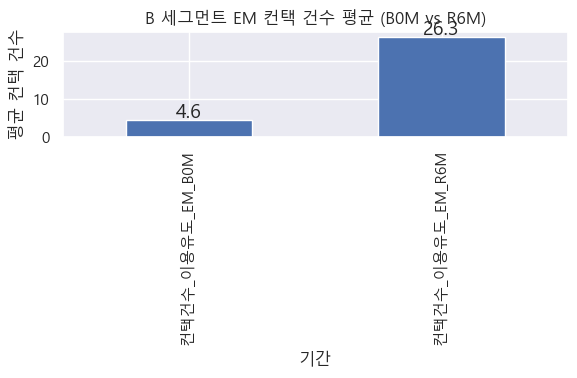

In [14]:
# B 세그먼트의 컨택건수(B0M vs R6M) 평균 비교 
b_means = b_df[['컨택건수_이용유도_EM_B0M','컨택건수_이용유도_EM_R6M']].mean()

plt.figure(figsize=(6,4))
ax2 = b_means.plot(kind='bar')
plt.title('B 세그먼트 EM 컨택 건수 평균 (B0M vs R6M)')
plt.xlabel('기간')
plt.ylabel('평균 컨택 건수')

# 막대 위에 값 표시
for p in ax2.patches:
    height = p.get_height()
    ax2.text(p.get_x() + p.get_width()/2, height + 0.5,
             f'{height:.1f}', ha='center')

plt.tight_layout()
plt.show()

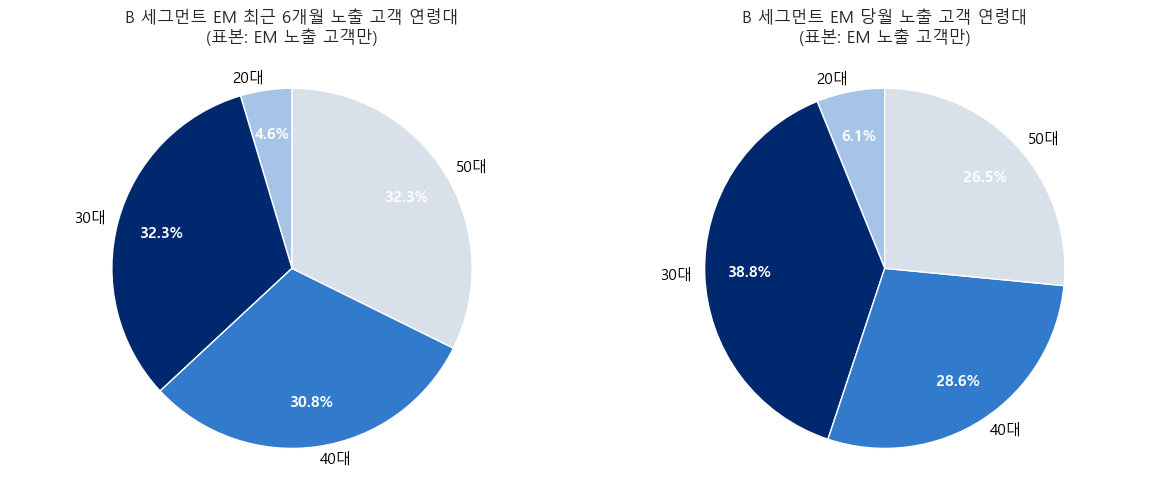

In [15]:
# B 세그먼트 데이터 정의
b_df = merged_df[merged_df['Segment']=='B'].copy()

# R6M 및 당월 노출 고객 연령대 비율 계산
age_prop_r6m = (
    b_df[b_df['컨택건수_이용유도_EM_R6M'] > 0]['연령']
     .value_counts(normalize=True)
     .sort_index()
)
age_prop_b0m = (
    b_df[b_df['컨택건수_이용유도_EM_B0M'] > 0]['연령']
     .value_counts(normalize=True)
     .sort_index()
)

# 고정 팔레트
colors = ['#A6C4E8', '#00286E', '#327ACC', '#D8E0EA']

# 1행 2열 subplot
fig, axes = plt.subplots(1, 2, figsize=(12,5), facecolor='white')

def draw_pie(ax, data, title):
    wedges, texts, autotexts = ax.pie(
        data.values,
        labels=[f"{age}" for age in data.index],
        colors=colors[:len(data)],
        startangle=90,
        pctdistance=0.75,
        labeldistance=1.07,
        autopct=lambda pct: f"{pct:.1f}%",
        wedgeprops={'edgecolor':'white','linewidth':1},
        textprops={'fontsize':11}
    )
    # 카테고리 라벨만 검은색으로, 퍼센트 라벨은 흰색으로
    for t in texts:
        t.set_color('black')
    for at in autotexts:
        at.set_color('white')
        at.set_weight('bold')
    ax.set_title(title, pad=20)
    ax.axis('equal')
    
draw_pie(
    axes[0],
    age_prop_r6m,
    'B 세그먼트 EM 최근 6개월 노출 고객 연령대\n(표본: EM 노출 고객만)'
)
draw_pie(
    axes[1],
    age_prop_b0m,
    'B 세그먼트 EM 당월 노출 고객 연령대\n(표본: EM 노출 고객만)'
)

plt.tight_layout()
plt.show()

B0M 기준 가장 활발한 연령대(메일): 30대 (평균 4.42회)
R6M 기준 가장 활발한 연령대(메일): 30대 (평균 26.11회)

B0M 기준 30대 세그먼트 분포(메일):
  Segment  비율
0       E   1
1       D   0
2       C   0
3       A   0
4       B   0

R6M 기준 30대 세그먼트 분포(메일):
  Segment  비율
0       E   1
1       D   0
2       C   0
3       A   0
4       B   0


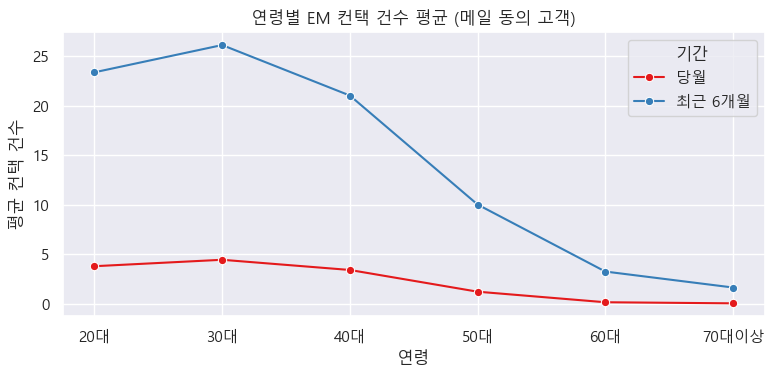

In [16]:
# 메일 수신 동의 고객만 필터 (0=동의, 1=거부)
mail_ok = merged_df[merged_df['수신거부여부_메일'] == 0]

# 연령별 B0M/R6M EM 평균 컨택 건수 계산
mail_age_activity = (
    mail_ok
    .groupby('연령')[['컨택건수_이용유도_EM_B0M', '컨택건수_이용유도_EM_R6M']]
    .mean()
    .reset_index()
)

# B0M 기준 가장 활발한 연령대
mail_top_age_B0M  = mail_age_activity.sort_values('컨택건수_이용유도_EM_B0M', ascending=False).iloc[0]['연령']
mail_top_mean_B0M = mail_age_activity.loc[mail_age_activity['연령'] == mail_top_age_B0M, '컨택건수_이용유도_EM_B0M'].values[0]

# R6M 기준 가장 활발한 연령대
mail_top_age_R6M  = mail_age_activity.sort_values('컨택건수_이용유도_EM_R6M', ascending=False).iloc[0]['연령']
mail_top_mean_R6M = mail_age_activity.loc[mail_age_activity['연령'] == mail_top_age_R6M, '컨택건수_이용유도_EM_R6M'].values[0]

print(f"B0M 기준 가장 활발한 연령대(메일): {mail_top_age_B0M} (평균 {mail_top_mean_B0M:.2f}회)")
print(f"R6M 기준 가장 활발한 연령대(메일): {mail_top_age_R6M} (평균 {mail_top_mean_R6M:.2f}회)")

# 해당 연령대들의 세그먼트 분포 계산
for period, age in [('B0M', mail_top_age_B0M), ('R6M', mail_top_age_R6M)]:
    dist = (
        mail_ok[mail_ok['연령'] == age]['Segment']
        .value_counts(normalize=True)
        .reset_index(name='비율')
        .rename(columns={'index': 'Segment'})
    )
    print(f"\n{period} 기준 {age} 세그먼트 분포(메일):")
    print(dist)

# 연령별 B0M/R6M 평균 EM 컨택 데이터용으로 melt
mail_age_melt = mail_age_activity.melt(
    id_vars='연령',
    value_vars=['컨택건수_이용유도_EM_B0M','컨택건수_이용유도_EM_R6M'],
    var_name='기간',
    value_name='평균컨택'
)
mail_age_melt['기간'] = mail_age_melt['기간'].map({
    '컨택건수_이용유도_EM_B0M': '당월',
    '컨택건수_이용유도_EM_R6M': '최근 6개월'
})

# 시각화
plt.figure(figsize=(8,4))
ax = sns.lineplot(
    data=mail_age_melt,
    x='연령',
    y='평균컨택',
    hue='기간',
    marker='o',
    palette=['#E41A1C', '#377EB8']
);
plt.title('연령별 EM 컨택 건수 평균 (메일 동의 고객)')
plt.xlabel('연령')
plt.ylabel('평균 컨택 건수')
plt.legend(title='기간')
plt.tight_layout()
plt.show()

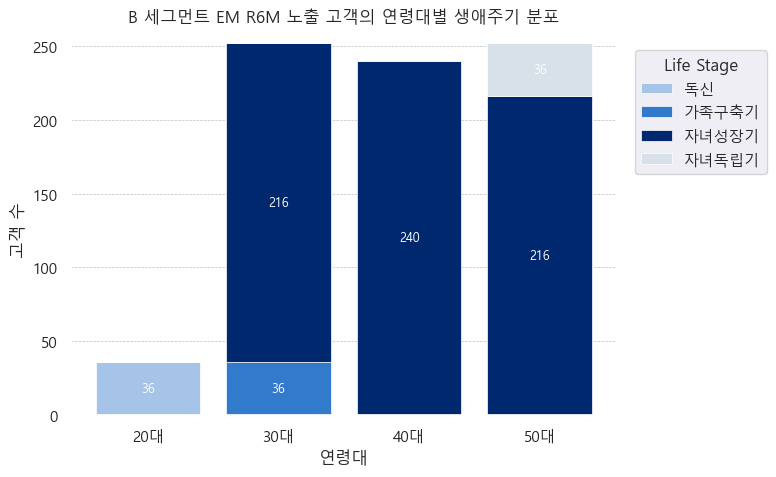

In [17]:
# B 세그먼트 & R6M EM 노출 고객만 필터링
b_exposed = merged_df[
    (merged_df['Segment']=='B') &
    (merged_df['컨택건수_이용유도_EM_R6M'] > 0)
].copy()

# Life_Stage 4단계로 리매핑
stage_map = {
    '독신': '독신',
    '가족구축기': '가족구축기',
    '자녀성장(1)': '자녀성장기',
    '자녀성장(2)': '자녀성장기',
    '자녀출산기': '자녀성장기',
    '자녀독립기': '자녀독립기'
}
b_exposed['stage4'] = b_exposed['Life_Stage'].map(stage_map)

# 연령대 × 리매핑된 생애주기별 고객 수 집계
age_stage_counts = pd.crosstab(
    index=b_exposed['연령'],
    columns=b_exposed['stage4']
).astype(int)

# 색상 팔레트 
palette = {
    '독신':      '#A6C4E8',  
    '가족구축기':'#327ACC',
    '자녀성장기':'#00286E',
    '자녀독립기':'#D8E0EA'   
}

# 스택형 바 차트 그리기
fig, ax = plt.subplots(figsize=(8,5), facecolor='white')
ax.set_facecolor('white')
ax.grid(axis='y', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
ax.set_axisbelow(True)

bottom = pd.Series(0, index=age_stage_counts.index)
for stage in ['독신','가족구축기','자녀성장기','자녀독립기']:
    vals = age_stage_counts.get(stage, pd.Series(0, index=age_stage_counts.index))
    ax.bar(
        age_stage_counts.index.astype(str),
        vals,
        bottom=bottom,
        label=stage,
        color=palette[stage],
        edgecolor='white',
        linewidth=0.5
    )
    bottom += vals

# 축 레이블, 제목
ax.set_title('B 세그먼트 EM R6M 노출 고객의 연령대별 생애주기 분포', pad=15)
ax.set_xlabel('연령대')
ax.set_ylabel('고객 수')
ax.set_xticks(range(len(age_stage_counts.index)))
ax.set_xticklabels(age_stage_counts.index.astype(str), rotation=0)

# 막대 내부 단계별 값 표시
for i, age in enumerate(age_stage_counts.index):
    cum = 0
    for stage in ['독신','가족구축기','자녀성장기','자녀독립기']:
        val = age_stage_counts.at[age, stage] if stage in age_stage_counts.columns else 0
        if val > 0:
            ax.text(
                i,
                cum + val/2,
                str(val),
                ha='center', va='center',
                color='white', fontsize=9
            )
        cum += val

# 범례
ax.legend(title='Life Stage', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()